In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import cv2
import torch
import pickle
import numpy as np
from utils.sim_utils import *
from utils.eval_utils import *
from utils.experiments_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.sim_utils import *
from utils.couzin_utils import *
from models.Generator import ModularPolicy
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Model Comparison using Swarm Metrics

In [ ]:
# GAIL Simulation

# load GAIL policies
gail_path = rf"..\results\Video pred-prey policy"
gail_prey_policy = ModularPolicy(features=5).to("cpu")
gail_prey_policy.load_state_dict(torch.load((os.path.join(gail_path, "prey_policy.pth")), map_location="cpu"))

gail_pred_policy = ModularPolicy(features=4).to("cpu")
gail_pred_policy.load_state_dict(torch.load((os.path.join(gail_path, "pred_policy.pth")), map_location="cpu"))

# run simulation with GAIL policies to get evaluation metrics
_, _, gail_metrics = run_env_simulation(visualization='off', 
                                        prey_policy=gail_prey_policy, 
                                        pred_policy=gail_pred_policy,
                                        n_prey=32, n_pred=1, 
                                        max_steps=200,
                                        pred_speed=5, prey_speed=5,
                                        area_width=50, area_height=50,
                                        max_turn = 0.25,
                                        step_size=0.5)

In [ ]:
# BC Simulation

# load BC policies
bc_path = rf"..\models\trained_policies\BC-Policy"
bc_prey_policy = ModularPolicy(features=5).to("cpu")
bc_prey_policy.load_state_dict(torch.load((os.path.join(bc_path, "bc_prey_policy.pt")), map_location="cpu"))

bc_pred_policy = ModularPolicy(features=4).to("cpu")
bc_pred_policy.load_state_dict(torch.load((os.path.join(bc_path, "bc_pred_policy.pt")), map_location="cpu"))

# run simulation with BC policies to get evaluation metrics
_, _, bc_metrics = run_env_simulation(visualization='off', 
                                    prey_policy=bc_prey_policy, 
                                    pred_policy=bc_pred_policy,
                                    n_prey=32, n_pred=1, 
                                    max_steps=200,
                                    pred_speed=5, prey_speed=5,
                                    area_width=50, area_height=50,
                                    max_turn = 0.25,
                                    step_size=0.5)

In [ ]:
# Couzin Simulation

# run Couzin simulation to get evaluation metrics
_, _, couzin_metrics, _, _ = run_couzin_simulation(visualization="off", max_steps=200, 
                                                constant_speed=5, shark_speed=5, 
                                                area_width=50, area_height=50,
                                                dt = 0.5, # step_size
                                                alpha=0.01, # social behavior - attack only
                                                theta_dot_max=0.5, theta_dot_max_shark=0.5,
                                                number_of_sharks=1, n=32)

In [ ]:
# Random Policy Simulation

# create random policies
random_prey_policy = ModularPolicy(features=5).to("cpu")
random_prey_policy.set_parameters()

random_pred_policy = ModularPolicy(features=4).to("cpu")
random_pred_policy.set_parameters()

# run simulation with random policies to get evaluation metrics
_, _, random_metrics = run_env_simulation(visualization='off', 
                                        prey_policy=random_prey_policy, 
                                        pred_policy=random_pred_policy,
                                        n_prey=32, n_pred=1, 
                                        max_steps=200,
                                        pred_speed=5, prey_speed=5,
                                        area_width=50, area_height=50,
                                        max_turn = 0.25,
                                        step_size=0.5)

In [6]:
# load expert data
expert_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected\expert_metrics_yd.pkl'
with open(expert_path, "rb") as f:
    expert_data = pickle.load(f)
expert_metrics = compute_expert_metrics(expert_data, 33)
print("Expert Metrics computed!")

# load init pool
init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path).to(device)
print("Init Pool Shape:", init_pool.shape)

Expert Metrics computed!
Init Pool Shape: torch.Size([240, 33, 3])


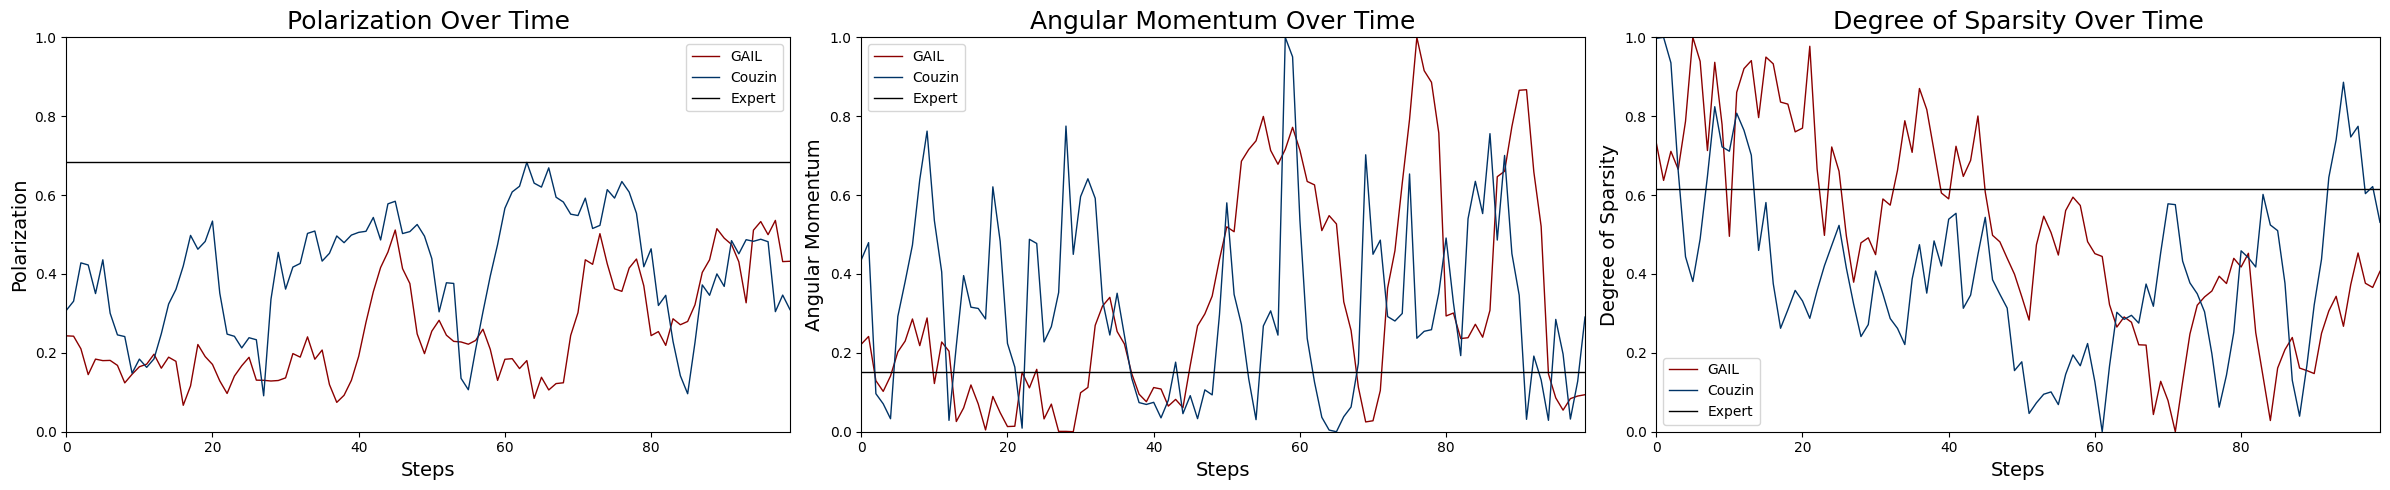

In [7]:
# plot swarm metrics for model comparisons
plot_swarm_metrics(gail_metrics=gail_metrics, couzin_metrics=couzin_metrics, expert_metrics=expert_metrics)

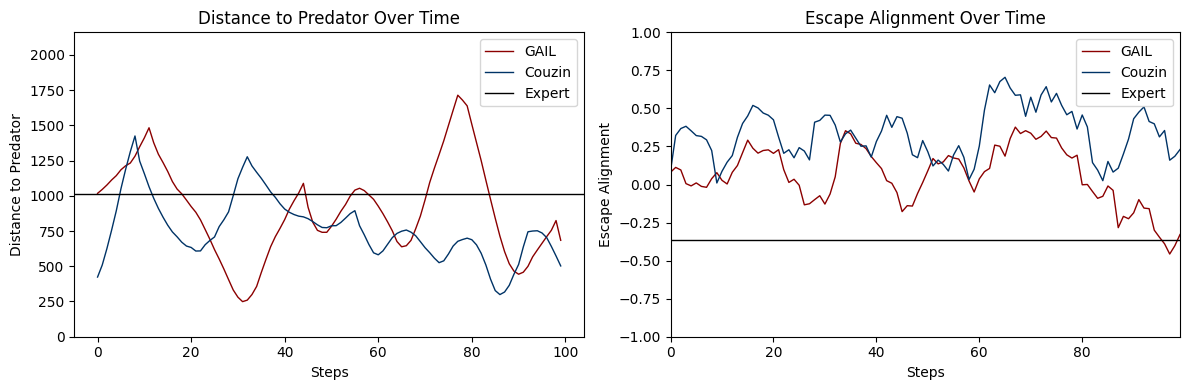

In [8]:
# plot pred-prey metrics for model comparisons
plot_pred_prey_metrics(gail_metrics=gail_metrics, couzin_metrics=couzin_metrics, expert_metrics=expert_metrics)

## Analysis of Modular Networks

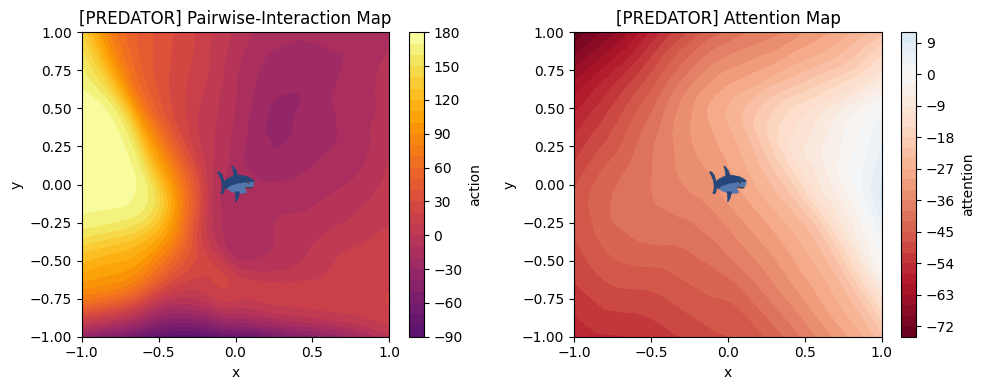

In [9]:
# load predator and prey icons
pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
prey_img_path = rf"..\data\3. Evaluation\images\prey.png"

# compute and plot predator policy maps
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(role="predator", pin=gail_pred_policy.pairwise, an=gail_pred_policy.attention)
plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

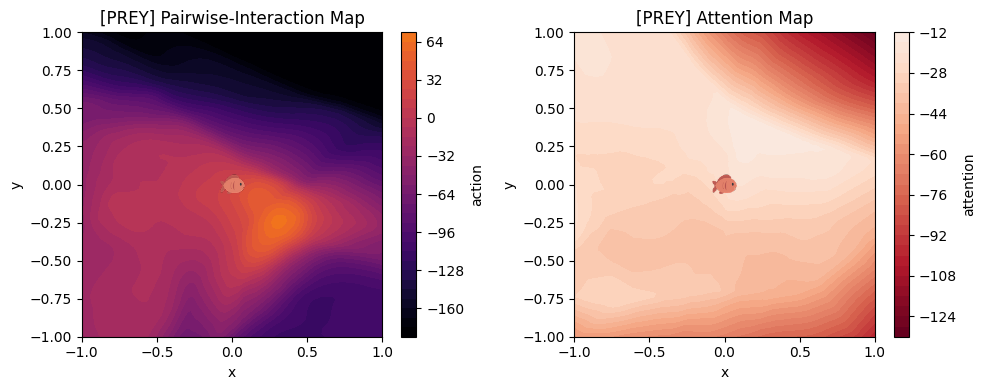

In [10]:
# compute and plot prey policy maps
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(role="prey", pin=gail_prey_policy.pairwise, an=gail_prey_policy.attention)
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

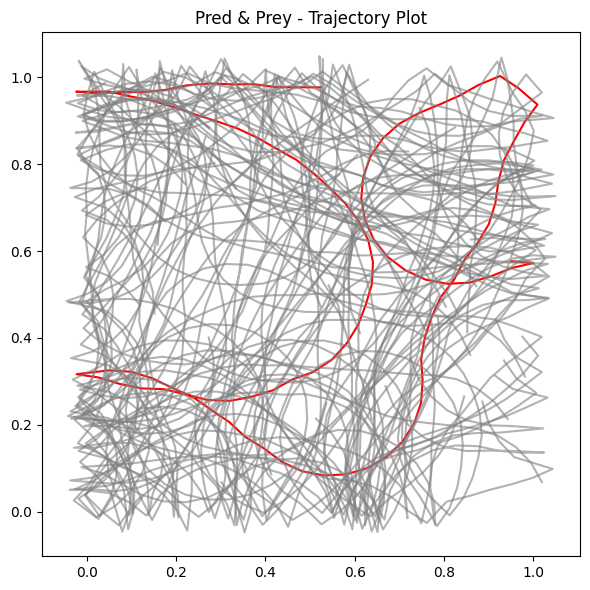

In [11]:
# plot the trajectories of agents
plot_trajectory(gail_metrics)

## Trajectory Prediction

Step 0 | Position Error: 0.0000 ± 0.0000 | Theta Error: 0.00° ± 0.00°
Step 1 | Position Error: 0.0042 ± 0.0000 | Theta Error: 14.93° ± 0.15°
Step 2 | Position Error: 0.0082 ± 0.0000 | Theta Error: 28.19° ± 1.13°
Step 3 | Position Error: 0.0119 ± 0.0000 | Theta Error: 40.61° ± 4.90°
Step 4 | Position Error: 0.0155 ± 0.0001 | Theta Error: 51.48° ± 10.44°
Step 5 | Position Error: 0.0189 ± 0.0001 | Theta Error: 63.14° ± 14.44°
Step 6 | Position Error: 0.0223 ± 0.0002 | Theta Error: 71.98° ± 18.93°
Step 7 | Position Error: 0.0260 ± 0.0002 | Theta Error: 79.27° ± 23.94°
Step 8 | Position Error: 0.0295 ± 0.0003 | Theta Error: 83.15° ± 26.76°
Step 9 | Position Error: 0.0331 ± 0.0004 | Theta Error: 88.98° ± 29.48°


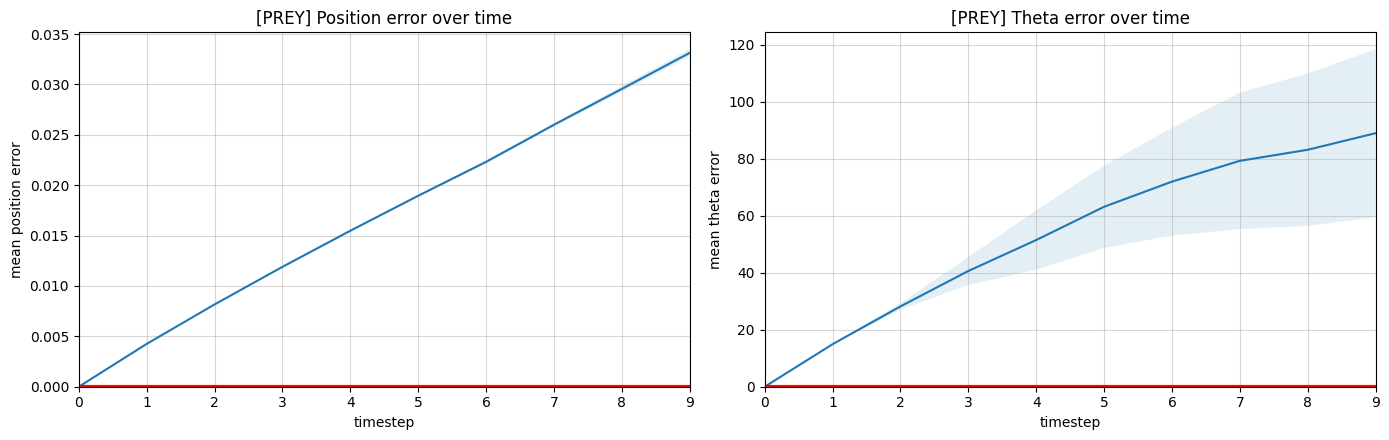

In [25]:
# compute trajectory offsets using GAIL policies
prey_positions = trajectory_offsets(gail_pred_policy, gail_prey_policy, init_pool, mc_samples=200, clip_idx=1, role="prey")

Step 0 | Position Error: 0.0000 ± 0.0000 | Theta Error: 0.00° ± 0.00°
Step 1 | Position Error: 0.0040 ± 0.0000 | Theta Error: 3.96° ± 3.08°
Step 2 | Position Error: 0.0079 ± 0.0000 | Theta Error: 15.92° ± 9.06°
Step 3 | Position Error: 0.0121 ± 0.0001 | Theta Error: 31.52° ± 11.43°
Step 4 | Position Error: 0.0156 ± 0.0002 | Theta Error: 48.62° ± 12.14°
Step 5 | Position Error: 0.0175 ± 0.0007 | Theta Error: 59.89° ± 10.17°
Step 6 | Position Error: 0.0206 ± 0.0013 | Theta Error: 69.28° ± 12.84°
Step 7 | Position Error: 0.0244 ± 0.0019 | Theta Error: 77.62° ± 16.60°
Step 8 | Position Error: 0.0281 ± 0.0025 | Theta Error: 85.05° ± 23.14°
Step 9 | Position Error: 0.0317 ± 0.0032 | Theta Error: 92.81° ± 28.55°


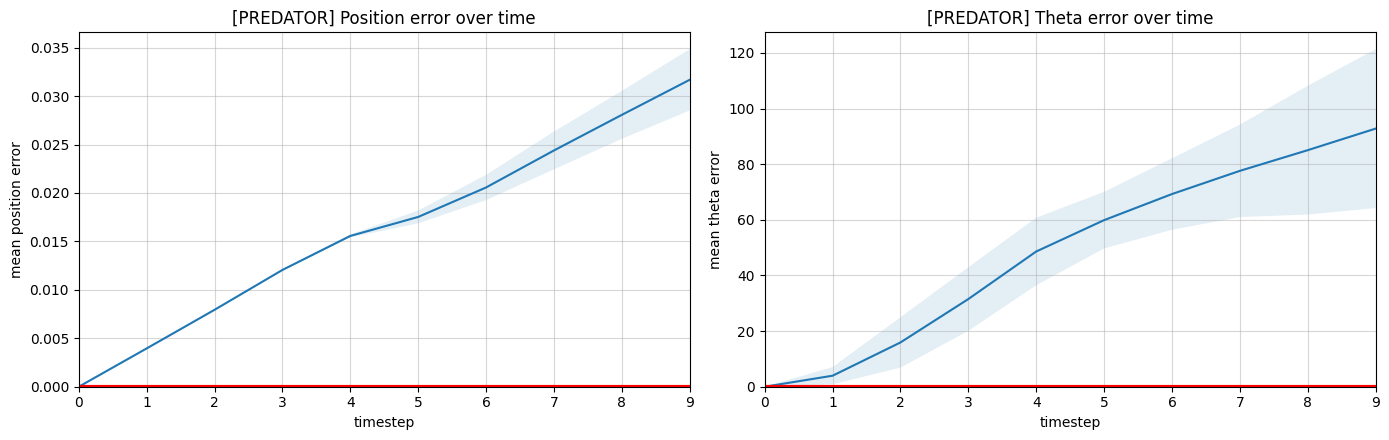

In [26]:
# compute trajectory offsets using GAIL policies
pred_positions = trajectory_offsets(gail_pred_policy, gail_prey_policy, init_pool, mc_samples=200, clip_idx=1, role="predator")

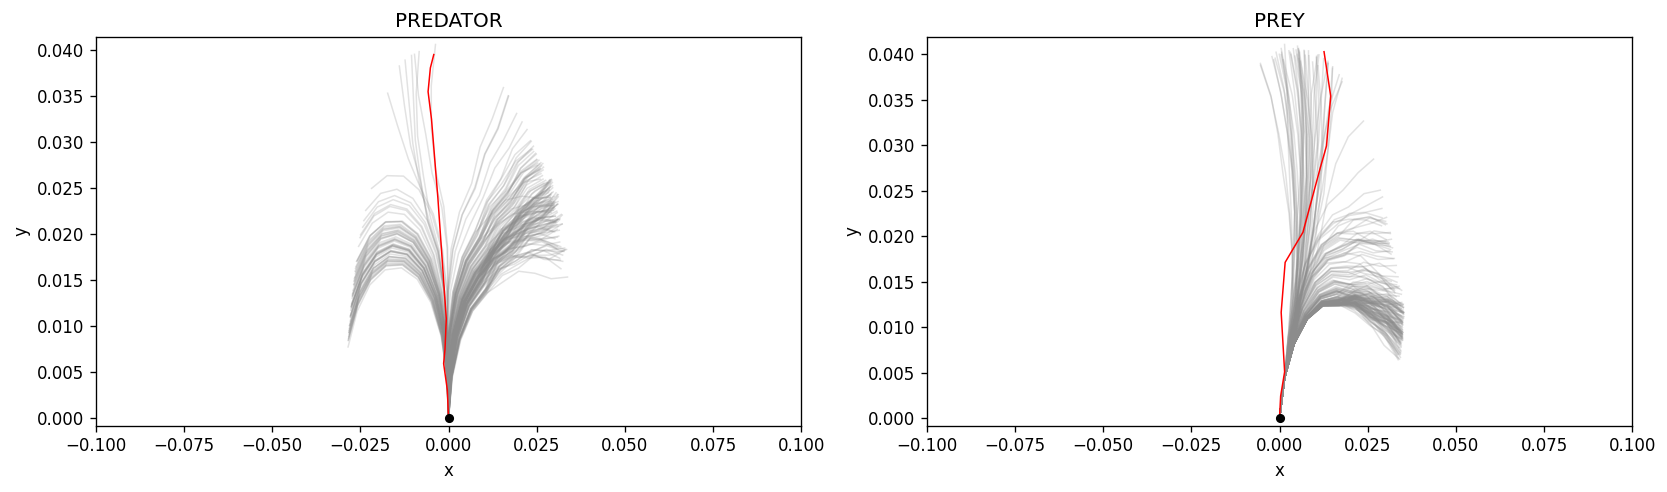

In [ ]:
# plot simulation trajectories of GAIL policies and expert trajectory for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4.2), dpi=120)  # wider figure
trajectory_plot(axes[0], agent_idx=0, role="Predator", positions=pred_positions, scale=4.5)
trajectory_plot(axes[1], agent_idx=21, role="Prey", positions=prey_positions, scale=9.1)

plt.tight_layout()
plt.show()

## Social Role Analysis

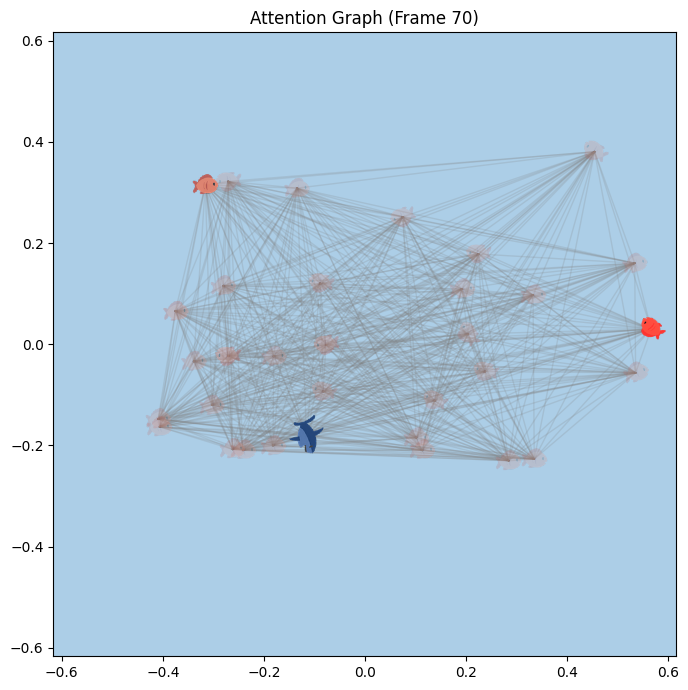

In [ ]:
# plot attention graph for a specific frame
draw_attention_graph(gail_metrics, frame_idx=70, pred_img_path=pred_img_path, prey_img_path=prey_img_path)

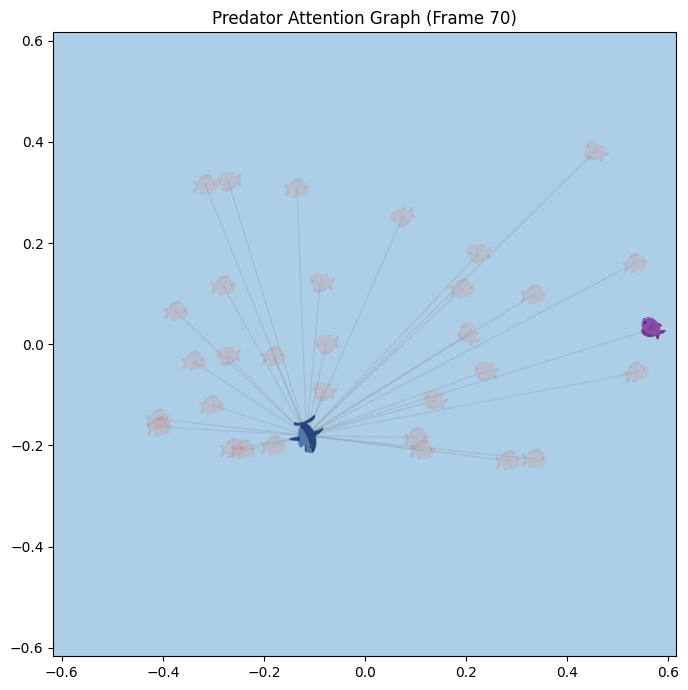

In [ ]:
# plot predator attention graph for a specific frame
draw_predator_attention_graph(gail_metrics, frame_idx=70, pred_img_path=pred_img_path, prey_img_path=prey_img_path)

In [ ]:
# create attention graph video
attn_graph_dir = rf"..\results\experiment garcia\attention graph frames"
record_attn_graph_video(gail_metrics, num_steps=10, pred_img_path=pred_img_path, prey_img_path=prey_img_path, save_dir=attn_graph_dir)

Saved frame 0/10
Video rendered!
